In [1]:
import pandas as pd
import numpy as np 
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu,f_oneway
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import os
from matplotlib import gridspec

import warnings
warnings.filterwarnings('ignore')


In [2]:
datasets = {
    "train": pd.read_parquet('/data/averaged_features_train.pq'),
    "test": pd.read_parquet('/data/averaged_features_test.pq'),
    "rwe": pd.read_parquet('/data/averaged_features_rwe.pq'),
}
cols = next(iter(datasets.values())).columns
all_features = cols[
    cols.get_loc('audspec_lengthL1norm_sma_range'): 
    cols.get_loc('mfcc_sma_de[14]_stddevFallingSlope') + 1
]
def compute_cohens_d(group1, group2):
    return (np.mean(group1) - np.mean(group2)) / np.sqrt((np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2) / 2)


In [3]:
def analyze_dataset_emotion(df, dataset_name):
    results = []
    for feature in all_features:
        if feature not in df.columns:
            continue
        group_h = df[df['emotion'] == 'healthy'][feature].dropna()
        group_d = df[df['emotion'] == 'depressed'][feature].dropna()
        if len(group_h) < 5 or len(group_d) < 5:
            continue

        # Normality
        norm_h = shapiro(group_h)[1] > 0.05 if len(group_h) >= 3 else False
        norm_d = shapiro(group_d)[1] > 0.05 if len(group_d) >= 3 else False
        normal = norm_h and norm_d
       
        # Statistical Test
        if normal and len(group_h) >= 2 and len(group_d) >= 2:
            try:
                equal_var = levene(group_h, group_d)[1] > 0.05
            except Exception:
                equal_var = False
            if equal_var:
                stat, p_val = ttest_ind(group_h, group_d, equal_var=True)
                test_type = 't-test'
            else:
                stat, p_val = mannwhitneyu(group_h, group_d, alternative='two-sided')
                test_type = 'mannwhitney'
        else:
            stat, p_val = mannwhitneyu(group_h, group_d, alternative='two-sided')
            test_type = 'mannwhitney'
        
        # Effect size
        cohens_d = compute_cohens_d(group_h, group_d)
        results.append({
                'Dataset': dataset_name,
                'Feature': feature,
                'Test': test_type,
                'P_value': p_val,
                'Effect Size': cohens_d,
                'mean_healthy': np.mean(group_h),
                'std_healthy': np.std(group_h),
                'mean_depressed': np.mean(group_d),
                'std_depressed': np.std(group_d),
                'n_healthy': len(group_h),
                'n_depressed': len(group_d),
                'higher_group': 'healthy' if np.mean(group_h) > np.mean(group_d) else 'depressed'
            })
    return pd.DataFrame(results)

def analyze_dataset_gender(df, dataset_name):
    results = []
    for feature in all_features:
        if feature not in df.columns:
            continue
        group_m = df[df['gender'] == 'male'][feature].dropna()
        group_f = df[df['gender'] == 'female'][feature].dropna()
        if len(group_m) < 5 or len(group_f) < 5:
            continue

        # Normality
        norm_m = shapiro(group_m)[1] > 0.05 if len(group_m) >= 3 else False
        norm_f = shapiro(group_f)[1] > 0.05 if len(group_f) >= 3 else False
        normal = norm_m and norm_f
        # Statistical Test
        if normal and len(group_m) >= 2 and len(group_f) >= 2:
            try:
                equal_var = levene(group_m, group_f)[1] > 0.05
            except Exception:
                equal_var = False
            if equal_var:
                stat, p_val = ttest_ind(group_m, group_f, equal_var=True)
                test_type = 't-test'
            else:
                stat, p_val = mannwhitneyu(group_m, group_f, alternative='two-sided')
                test_type = 'mannwhitney'
        else:
            stat, p_val = mannwhitneyu(group_m, group_f, alternative='two-sided')
            test_type = 'mannwhitney'
        # Effect size
        cohens_d = compute_cohens_d(group_m, group_f)
        results.append({
                'Dataset': dataset_name,
                'Feature': feature,
                'Test': test_type,
                'P_value': p_val,
                'Effect Size': cohens_d,
                'mean_male': np.mean(group_m),
                'std_male': np.std(group_m),
                'mean_female': np.mean(group_f),
                'std_female': np.std(group_f),
                'n_male': len(group_m),
                'n_female': len(group_f),
                'higher_group': 'male' if np.mean(group_m) > np.mean(group_f) else 'female'
            })
    return pd.DataFrame(results)

all_emotion_results = pd.concat([
    analyze_dataset_emotion(datasets['train'], 'train'),
    analyze_dataset_emotion(datasets['test'], 'test'),
    analyze_dataset_emotion(datasets['rwe'], 'rwe')
])

all_gender_results = pd.concat([
    analyze_dataset_gender(datasets['train'], 'train'),
    analyze_dataset_gender(datasets['test'], 'test'),
    analyze_dataset_gender(datasets['rwe'], 'rwe')
])
from statsmodels.stats.multitest import multipletests

# Apply FDR correction within each dataset and question
all_emotion_results['P-Adjusted'] = np.nan
all_gender_results['P-Adjusted'] = np.nan
for (dataset), group in all_emotion_results.groupby(['Dataset']):
    corrected = multipletests(group['P_value'], method='fdr_bh')[1]
    all_emotion_results.loc[group.index, 'P-Adjusted'] = pd.Series(corrected, index=group.index)
for (dataset), group in all_gender_results.groupby(['Dataset']):
    corrected = multipletests(group['P_value'], method='fdr_bh')[1]
    all_gender_results.loc[group.index, 'P-Adjusted'] = pd.Series(corrected, index=group.index)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_unified_results(all_result, use_absolute_effects=True, top_k=20):

    available_datasets = sorted(all_result['Dataset'].unique())
    sample_sizes = {'rwe': 160, 'test': 333, 'train': 1323}
    total_n = sum(sample_sizes.values())
    weights = {ds: n / total_n for ds, n in sample_sizes.items()}
    print("weight of datasets:")
    for ds, weight in weights.items():
        print(f"  {ds}: {weight:.3f} (n={sample_sizes[ds]})")

    filtered_results = all_result[
            (all_result['P-Adjusted'] < 0.05) & 
            (all_result['Effect Size'].abs() > 0.5)
        ].copy()
    print(f"scanned features: {len(filtered_results)}")
    
    feature_dataset_count = filtered_results.groupby('Feature')['Dataset'].nunique()
    common_features = feature_dataset_count[
        feature_dataset_count == len(available_datasets)
    ].index.tolist()
    print(f"common features: {len(common_features)}")

    common_data = filtered_results[filtered_results['Feature'].isin(common_features)]
    effect_matrix = common_data.pivot_table(
        index='Feature', 
        columns='Dataset', 
        values='Effect Size',
        aggfunc='first'  
    ).reset_index()

    effect_matrix = effect_matrix.dropna()
    
    effect_cols = available_datasets
    if use_absolute_effects:
        effect_values = {ds: effect_matrix[ds].abs() for ds in effect_cols}
    else:
        effect_values = {ds: effect_matrix[ds] for ds in effect_cols}
    weighted_mean_effects = sum(
        weights[ds] * effect_values[ds] for ds in effect_cols
    )
    effect_matrix['Weighted_Mean_Effect_Size'] = weighted_mean_effects
    effect_matrix = effect_matrix.sort_values(
        'Weighted_Mean_Effect_Size', ascending=False
    ).reset_index(drop=True)
    rename_dict = {ds: f'Effect_Size_{ds}' for ds in available_datasets}
    effect_matrix = effect_matrix.rename(columns=rename_dict)
    
    return effect_matrix, available_datasets, weights

def plot_forest_plot(effect_matrix, available_datasets, top_k=20):
    plot_data = effect_matrix.nlargest(top_k, 'Weighted_Mean_Effect_Size').reset_index(drop=True)
    feature_to_number = {feature: i + 1 for i, feature in enumerate(plot_data['Feature'])}
    number_to_feature = {v: k for k, v in feature_to_number.items()}
    plot_data['Feature_Number'] = plot_data['Feature'].map(feature_to_number)
    colors = ['#FF6B6B', '#4ECD94', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    markers = ['o', 's', '^', 'v', '<', '>']
    
    dataset_colors = {ds: colors[i % len(colors)] for i, ds in enumerate(available_datasets)}
    dataset_markers = {ds: markers[i % len(markers)] for i, ds in enumerate(available_datasets)}
    
    label_mapping = {
        'train': 'Training set',
        'test': 'Internal validation', 
        'rwe': 'External validation'
    }
    
    plt.figure(figsize=(12, max(8, len(plot_data) * 0.4)))
    for i, row in plot_data.iterrows():
        y_pos = row['Feature_Number']
        
        for ds in available_datasets:
            effect_col = f'Effect_Size_{ds}'
            label = label_mapping.get(ds, ds.title())
            effect_value = abs(row[effect_col])
            plt.scatter(
                effect_value, y_pos,
                marker=dataset_markers[ds], 
                s=100, 
                c=dataset_colors[ds], 
                alpha=0.8,
                edgecolors='black', 
                linewidth=1,
                label=label if i == 0 else ""
            )

        scatter_weighted = plt.scatter(
            row['Weighted_Mean_Effect_Size'], y_pos,
            marker='D', s=120, 
            c=row['Weighted_Mean_Effect_Size'],
            cmap='viridis', alpha=0.9,
            edgecolors='red', linewidth=2,
            vmin=plot_data['Weighted_Mean_Effect_Size'].min(),
            vmax=plot_data['Weighted_Mean_Effect_Size'].max(),
            label='Weighted Mean' if i == 0 else ""
        )
    
    cbar = plt.colorbar(scatter_weighted)
    cbar.set_label('Weighted Mean Effect Size', fontsize=12)
    plt.title('Features Effects Across Datasets', fontsize=14, pad=20)
    plt.xlabel('Effect Size', fontsize=12)
    plt.ylabel('Feature Rank', fontsize=12)
    plt.legend(loc='upper right', framealpha=0.9, fontsize=10)
    plt.grid(alpha=0.3, linestyle='--')

    plt.ylim(0.5, len(plot_data) + 0.5)
    plt.yticks(range(1, len(plot_data) + 1))
    
    legend_text = [f"{letter}: {feature}" for letter, feature in number_to_feature.items()]
    plt.gcf().text(1.2, 0.5, "\n".join(legend_text), fontsize=10, va='center', ha='left', 
               transform=plt.gca().transAxes,
               bbox=dict(boxstyle="round,pad=0.5", facecolor='white'))
    plt.subplots_adjust(right=0.75) 
    plt.tight_layout()
    plt.show()
    return plot_data



weight of datasets:
  rwe: 0.088 (n=160)
  test: 0.183 (n=333)
  train: 0.729 (n=1323)
scanned features: 1442
common features: 26
Dataset                                     Feature  Effect_Size_rwe  \
0           audspec_lengthL1norm_sma_peakDistStddev           -1.099   
1        audspec_lengthL1norm_sma_de_peakDistStddev           -1.077   
2             audspec_lengthL1norm_sma_meanPeakDist           -0.977   
3                 audSpec_Rfilt_sma_de[5]_quartile3            1.303   
4          audspec_lengthL1norm_sma_de_meanPeakDist           -0.855   
5                 audSpec_Rfilt_sma_de[4]_quartile3            1.340   
6                  pcm_RMSenergy_sma_peakDistStddev           -0.776   
7                    pcm_RMSenergy_sma_meanPeakDist           -0.780   
8                    audSpec_Rfilt_sma_de[4]_iqr2-3            1.137   
9                    audSpec_Rfilt_sma_de[5]_iqr2-3            1.093   

Dataset  Effect_Size_test  Effect_Size_train  Weighted_Mean_Effect_Size  
0  

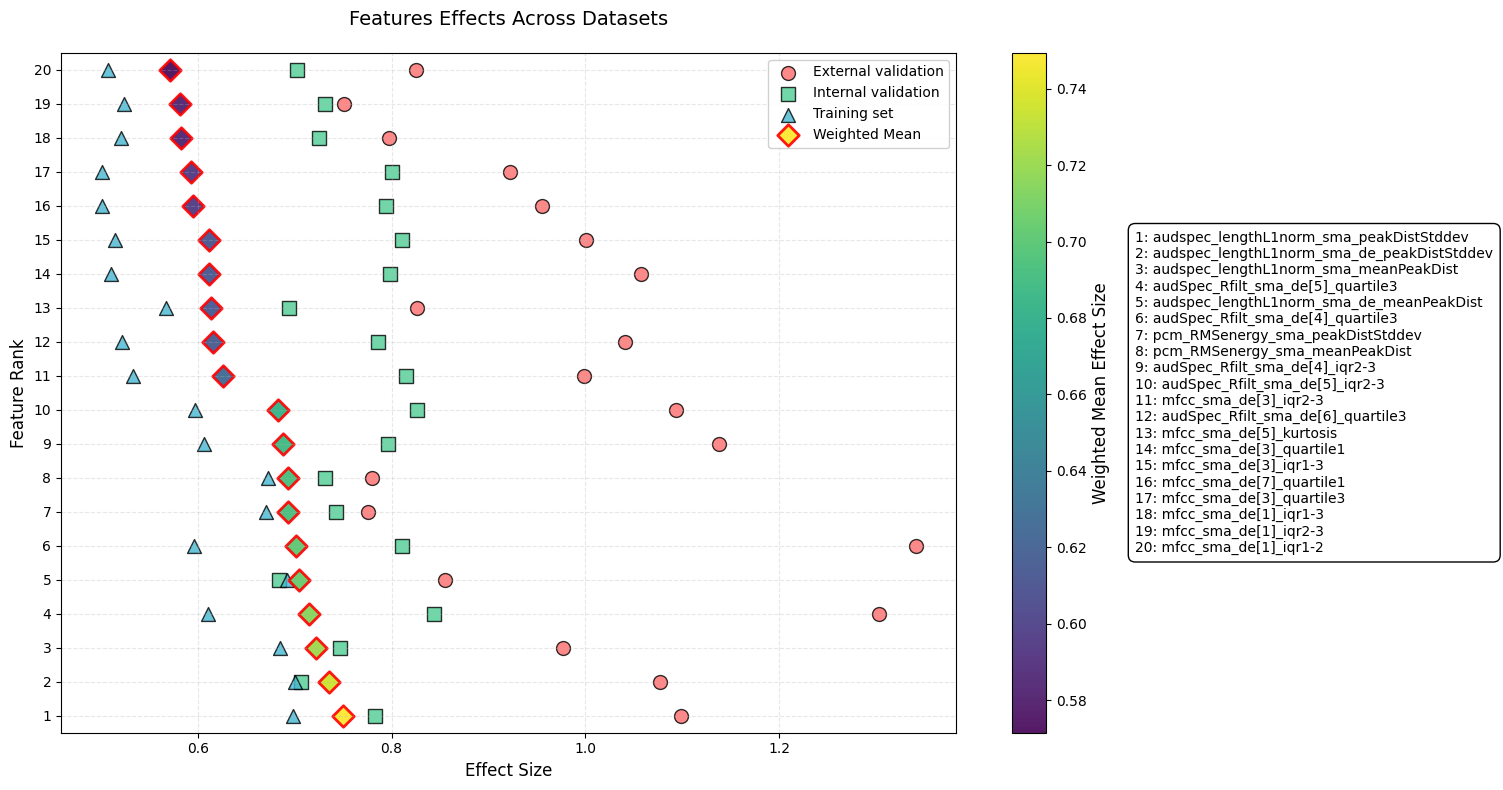

In [5]:
# ===========================
# emotion analysis (fig.2a)
# ===========================
if __name__ == "__main__":
    result_matrix, datasets, weights = process_unified_results(
            all_emotion_results, 
            use_absolute_effects=True,  
            top_k=20
        )
    display_cols = ['Feature'] + [f'Effect_Size_{ds}' for ds in datasets] + ['Weighted_Mean_Effect_Size']
    print(result_matrix[display_cols].head(10).round(3))
    plot_data = plot_forest_plot(result_matrix, datasets, top_k=20)

weight of datasets:
  rwe: 0.088 (n=160)
  test: 0.183 (n=333)
  train: 0.729 (n=1323)
scanned features: 2454
common features: 510
Dataset                     Feature  Effect_Size_rwe  Effect_Size_test  \
0             F0final_sma_quartile2           -4.078            -2.051   
1             F0final_sma_quartile1           -3.672            -2.031   
2             F0final_sma_quartile3           -3.847            -1.867   
3                 F0final_sma_amean           -3.742            -1.918   
4              F0final_sma_posamean           -3.742            -1.918   
5                F0final_sma_rqmean           -3.622            -1.856   
6        mfcc_sma[10]_percentile1.0            2.077             1.542   
7        mfcc_sma[14]_percentile1.0            2.494             1.601   
8            mfcc_sma[10]_quartile1            1.945             1.377   
9               mfcc_sma[14]_rqmean           -2.203            -1.526   

Dataset  Effect_Size_train  Weighted_Mean_Effect_Size 

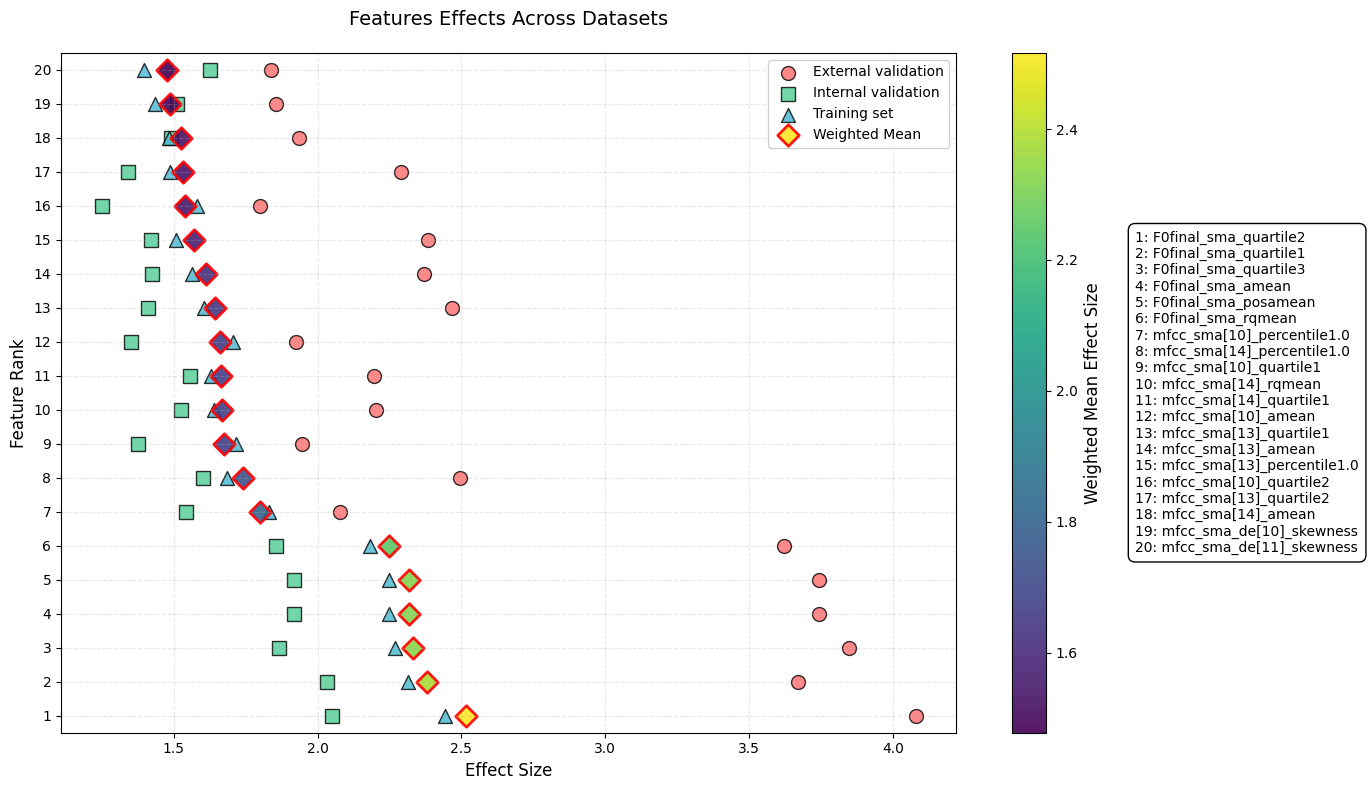

In [6]:
# ===========================
# gender analysis (fig.2b)
# ===========================
if __name__ == "__main__":
    result_matrix, datasets, weights = process_unified_results(
            all_gender_results, 
            use_absolute_effects=True,  
            top_k=20
        )
    display_cols = ['Feature'] + [f'Effect_Size_{ds}' for ds in datasets] + ['Weighted_Mean_Effect_Size']
    print(result_matrix[display_cols].head(10).round(3))
    plot_data = plot_forest_plot(result_matrix, datasets, top_k=20)

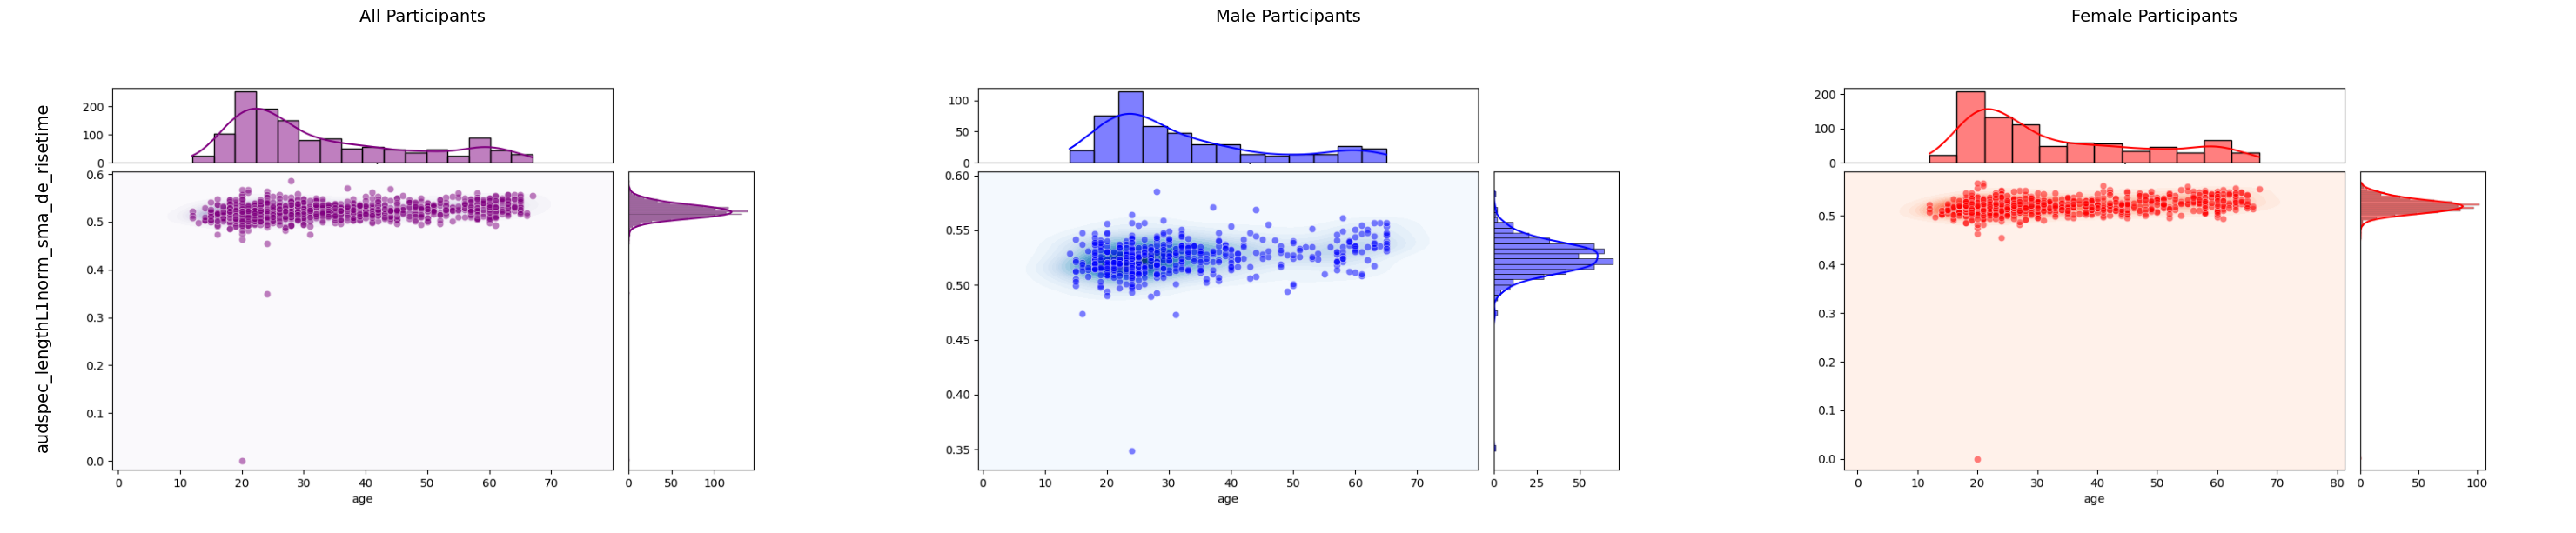

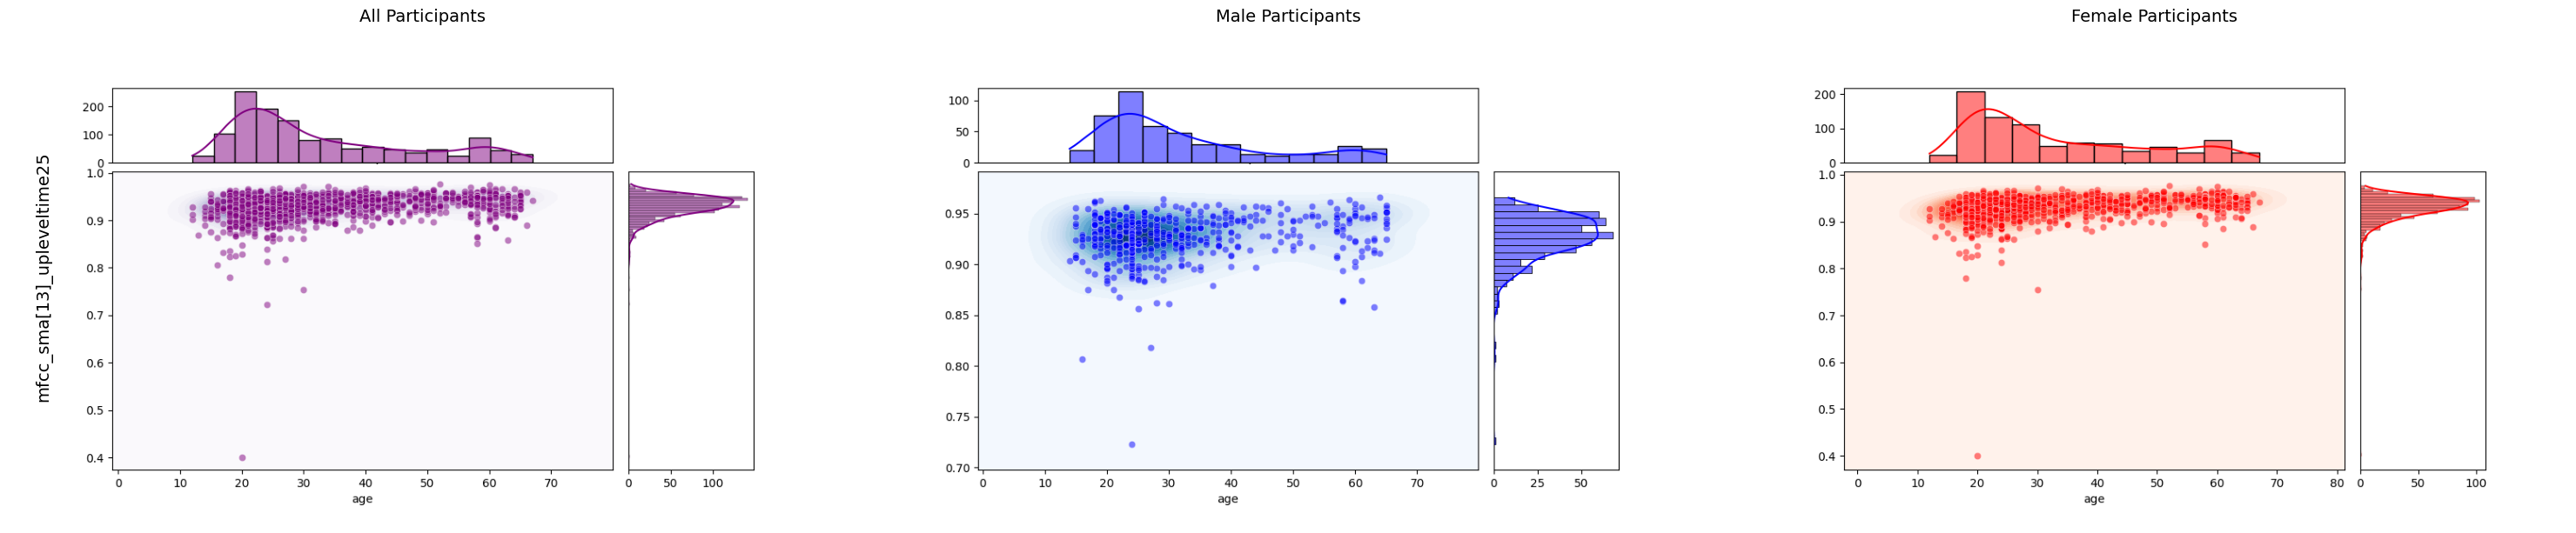

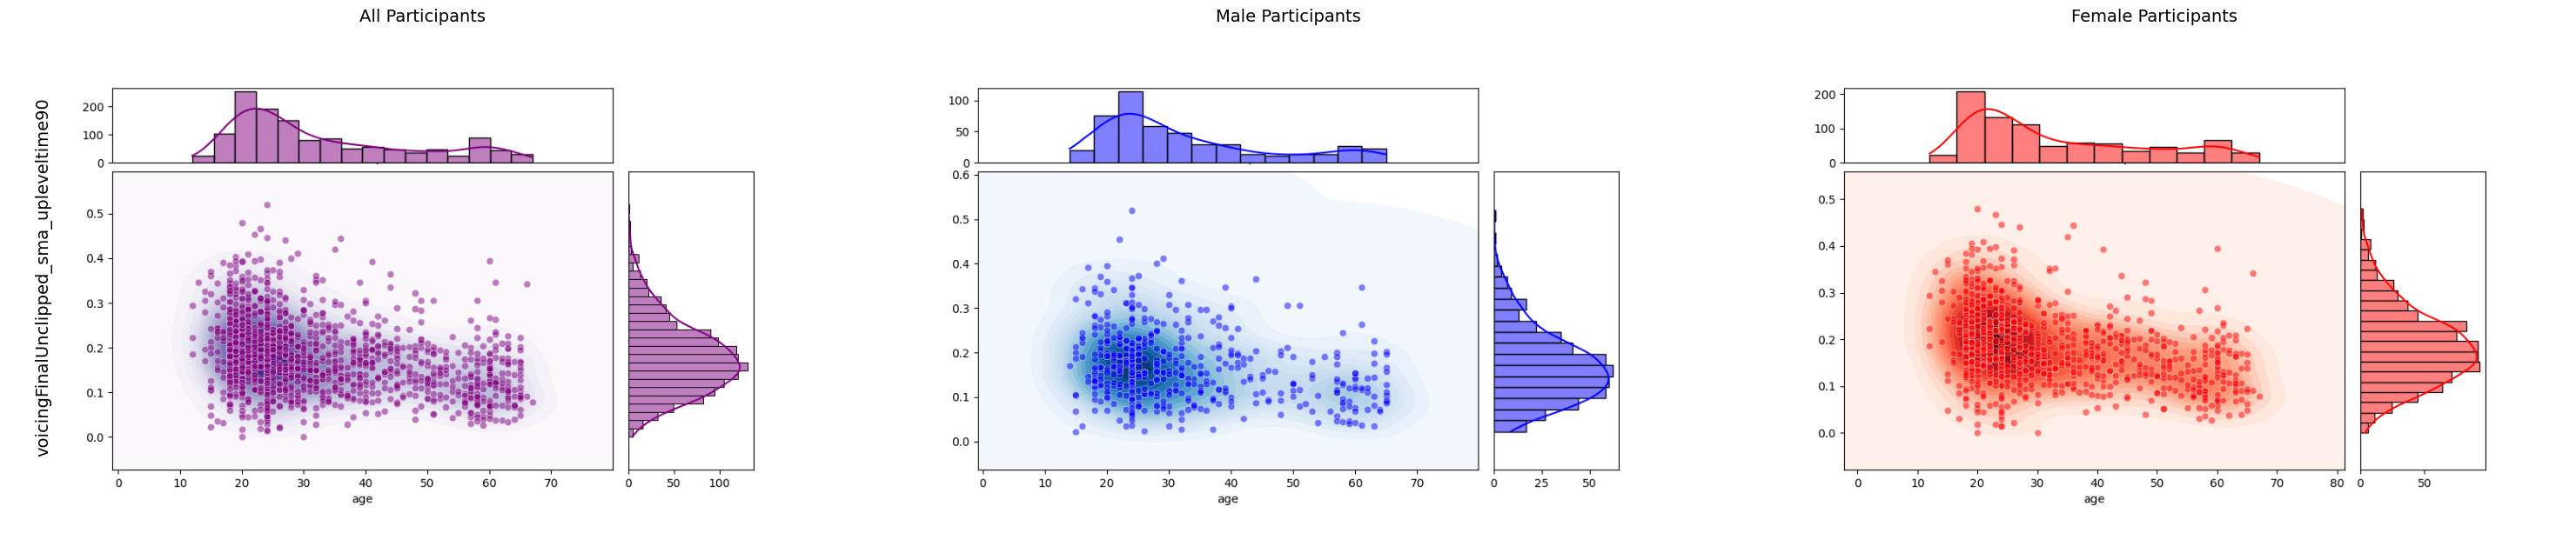

In [8]:
# ===========================
# age scatter plot （fig.2c）
# ===========================

df = pd.read_parquet('/data/averaged_features_train.pq')
male_df = df[df['gender'] == 'male']
female_df = df[df['gender'] == 'female']
correlations = df[all_features].corrwith(df['age'], method='spearman').sort_values(ascending=False)
correlation_results = pd.DataFrame({
    'age_Correlation': correlations,
})
strong_age = correlations[correlations.abs() > 0.3].sort_values(ascending=False)
strong_age_df = strong_age.reset_index()
strong_age_df.columns = ['Feature', 'age_Correlation']
features = strong_age_df['Feature'].tolist()
for feature in features:
    def plot_combined(data, title, feature, cmap, color, main_title):
        fig = plt.figure(figsize=(10, 6))
        gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

    # main plot (scatter + KDE)
        ax_main = fig.add_subplot(gs[1, 0])
        sns.kdeplot(data=data, x='age', y=feature, fill=True, thresh=0, cmap=cmap, levels=20, ax=ax_main)
        sns.scatterplot(data=data, x='age', y=feature, alpha=0.5, color=color, ax=ax_main)
        ax_main.set_title(title, pad=10)
        ax_main.set_xlabel("age")
        ax_main.set_ylabel("")

    # upper marginal histogram
        ax_top_hist = fig.add_subplot(gs[0, 0], sharex=ax_main)
        sns.histplot(data=data, x='age', kde=True, color=color, ax=ax_top_hist)
        ax_top_hist.set_xlabel("")
        ax_top_hist.set_ylabel("")
        ax_top_hist.tick_params(axis="x", bottom=False, labelbottom=False)  

    # right marginal histogram
        ax_right_hist = fig.add_subplot(gs[1, 1], sharey=ax_main)
        sns.histplot(data=data, y=feature, kde=True, color=color, ax=ax_right_hist)
        ax_right_hist.set_ylabel("")
        ax_right_hist.set_xlabel("")
        ax_right_hist.tick_params(axis="y", left=False, labelleft=False)  

        plt.suptitle(main_title, fontsize=16, y=0.95) 
        plt.tight_layout(rect=[0, 0, 1, 0.95])  
        plt.close()
        return fig  
    # plot 
    fig1 = plot_combined(df, "All Participants", feature, cmap='Purples', color='purple', main_title=None) 
    fig2 = plot_combined(male_df, "Male Participants", feature, cmap='Blues', color='blue', main_title=None)
    fig3 = plot_combined(female_df, "Female Participants", feature, cmap='Reds', color='red', main_title=None)
    n_cols = 3  
    subplot_width = 10
    subplot_height = 6  
    figsize = (n_cols * subplot_width, subplot_height)  
    fig, axes = plt.subplots(1, n_cols, figsize=figsize) 
    fig1.axes[0].figure.canvas.draw()  
    axes[0].imshow(fig1.canvas.buffer_rgba())  
    axes[0].axis('off')  
    axes[0].set_title("All Participants", fontsize=14)
    fig2.axes[0].figure.canvas.draw()  
    axes[1].imshow(fig2.canvas.buffer_rgba())  
    axes[1].axis('off') 
    axes[1].set_title("Male Participants", fontsize=14)
    fig3.axes[0].figure.canvas.draw() 
    axes[2].imshow(fig3.canvas.buffer_rgba())  
    axes[2].axis('off')  
    axes[2].set_title("Female Participants", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 1])  
    fig.text(0.02, 0.5, feature, fontsize=14, va='center', rotation='vertical') 